# *Import Packages*

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


# *Read CSV File*

In [2]:
data_path = r"C:/Users/saran/OneDrive/Desktop/PatrollQ/PatrolIQ Clean/last_partrollq_data_clean.csv"

df = pd.read_csv(data_path)
df.head(2)

id case_number                 date                block  iucr  \
0  13257111    JG480008  2023-10-26 19:36:00  004XX S PLYMOUTH CT  051A   
1  13257757    JG480569  2023-10-26 19:38:00   009XX S RACINE AVE  0810   

  primary_type           description                    location_description  \
0      ASSAULT  AGGRAVATED - HANDGUN                                  STREET   
1        THEFT             OVER $500  PARKING LOT / GARAGE (NON RESIDENTIAL)   

   arrest  domestic  ...           updated_on   latitude  longitude  \
0    True     False  ...  2023-11-03 15:41:45  41.876587 -87.628727   
1   False     False  ...  2023-11-03 15:41:45  41.870101 -87.656776   

                               location month  day      time  hour month_name  \
0  \n,  \n(41.876587174, -87.628727499)    10   26  19:36:00    19    October   
1  \n,  \n(41.870101037, -87.656775686)    10   26  19:38:00    19    October   

   time_float  
0   19.600000  
1   19.633333  

[2 rows x 28 columns]

# *Elbow Methods in Latitude, Longitude*

In [3]:
df_cluster = df.dropna(subset=['latitude', 'longitude']).copy()
X = df_cluster[['latitude', 'longitude']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


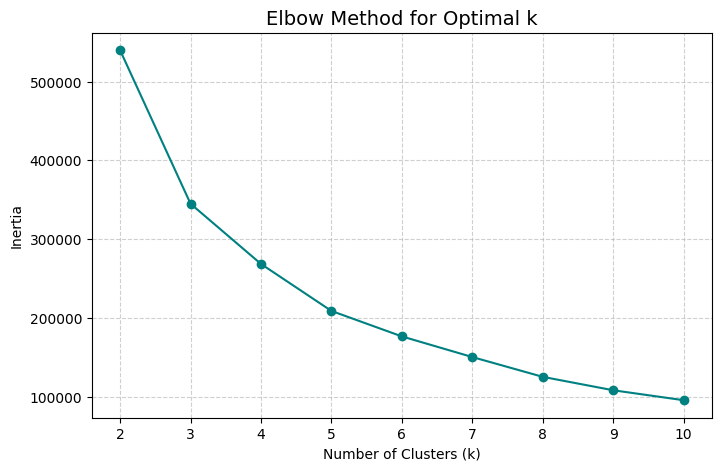

In [4]:
inertia = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='teal')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# *Make Clusters*

# **K-Mean Cluster**

In [13]:
k_mean = 4
kmeans = KMeans(n_clusters=k_mean, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

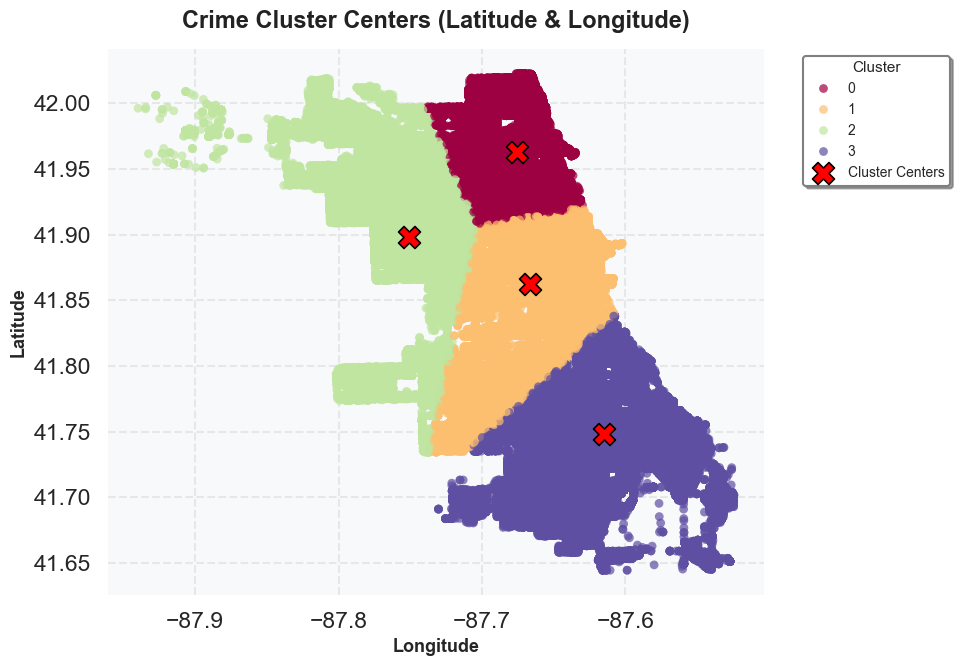

In [7]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'axes.facecolor': '#f8f9fa',
    'figure.facecolor': '#ffffff'
})

centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=df_cluster,
    x='longitude',
    y='latitude',
    hue='cluster',
    palette='Spectral',
    alpha=0.7,
    s=40,
    edgecolor='none'
)

plt.scatter(
    centers[:, 1],
    centers[:, 0],
    s=250,
    c='red',
    marker='X',
    edgecolors='black',
    linewidths=1.2,
    label='Cluster Centers'
)

ax.set_title('Crime Cluster Centers (Latitude & Longitude)', fontsize=17, weight='bold', pad=15, color='#222222')
ax.set_xlabel('Longitude', fontsize=13, weight='semibold')
ax.set_ylabel('Latitude', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    shadow=True,
    fontsize=10,
    title_fontsize=11
)

ax.grid(True, linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


# *Clusters Visuals by Distribution of Primary Crime Types per Cluster*

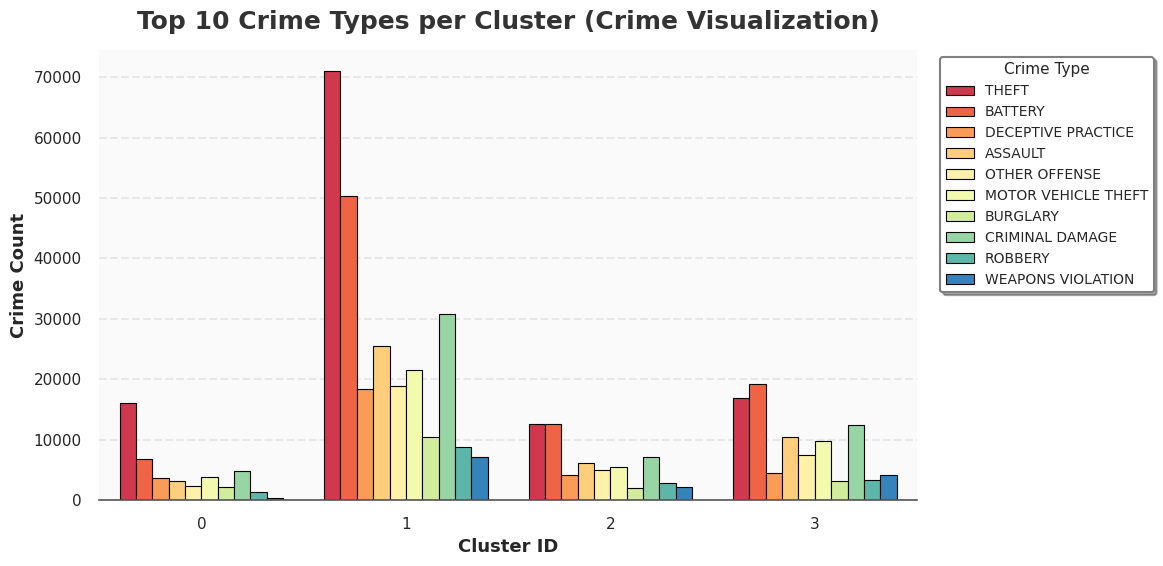

In [39]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = df_cluster.loc[X.index].copy()
df_pca['pca1'] = X_pca[:, 0]
df_pca['pca2'] = X_pca[:, 1]


top10_primary = df_pca['primary_type'].value_counts().head(10).index
df_top10 = df_pca[df_pca['primary_type'].isin(top10_primary)]


sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 1.2

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df_top10,
    x='cluster',
    hue='primary_type',
    palette='Spectral',      
    edgecolor='black',      
    linewidth=0.8,
    saturation=1
)


ax.set_title(
    'Top 10 Crime Types per Cluster (Crime Visualization)',
    fontsize=18, weight='bold', pad=15, color='#333333'
)
ax.set_xlabel('Cluster ID', fontsize=13, weight='semibold')
ax.set_ylabel('Crime Count', fontsize=13, weight='semibold')


ax.tick_params(axis='x', labelsize=11, rotation=0)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(left=True)


plt.legend(
    title='Crime Type',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)


ax.set_facecolor('#fafafa')      
plt.gcf().set_facecolor('#ffffff') 


for spine in ax.spines.values():
    spine.set_edgecolor('#555555')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

In [41]:
summary = (
    df_top10
    .groupby(['cluster', 'primary_type'])
    .size()
    .reset_index(name='crime_count')
    .sort_values(['cluster', 'crime_count'], ascending=[True, False])
)

summary

cluster         primary_type  crime_count
8         0                THEFT        16060
1         0              BATTERY         6864
3         0      CRIMINAL DAMAGE         4874
5         0  MOTOR VEHICLE THEFT         3763
4         0   DECEPTIVE PRACTICE         3639
0         0              ASSAULT         3192
6         0        OTHER OFFENSE         2354
2         0             BURGLARY         2142
7         0              ROBBERY         1365
9         0    WEAPONS VIOLATION          359
18        1                THEFT        70972
11        1              BATTERY        50326
13        1      CRIMINAL DAMAGE        30853
10        1              ASSAULT        25540
15        1  MOTOR VEHICLE THEFT        21494
16        1        OTHER OFFENSE        18839
14        1   DECEPTIVE PRACTICE        18463
12        1             BURGLARY        10377
17        1              ROBBERY         8773
19        1    WEAPONS VIOLATION         7162
21        2              BATTERY        12562
28        2                THEFT        12557
23        2      CRIMINAL DAMAGE         7130
20        2              ASSAULT         6146
25        2  MOTOR VEHICLE THEFT         5550
26        2        OTHER OFFENSE         5059
24        2   DECEPTIVE PRACTICE         4178
27        2              ROBBERY         2799
29        2    WEAPONS VIOLATION         2132
22        2             BURGLARY         1918
31        3              BATTERY        19206
38        3                THEFT        16864
33        3      CRIMINAL DAMAGE        12467
30        3              ASSAULT        10465
35        3  MOTOR VEHICLE THEFT         9748
36        3        OTHER OFFENSE         7543
34        3   DECEPTIVE PRACTICE         4442
39        3    WEAPONS VIOLATION         4209
37        3              ROBBERY         3324
32        3             BURGLARY         3184

# *Clusters Visual by location description*

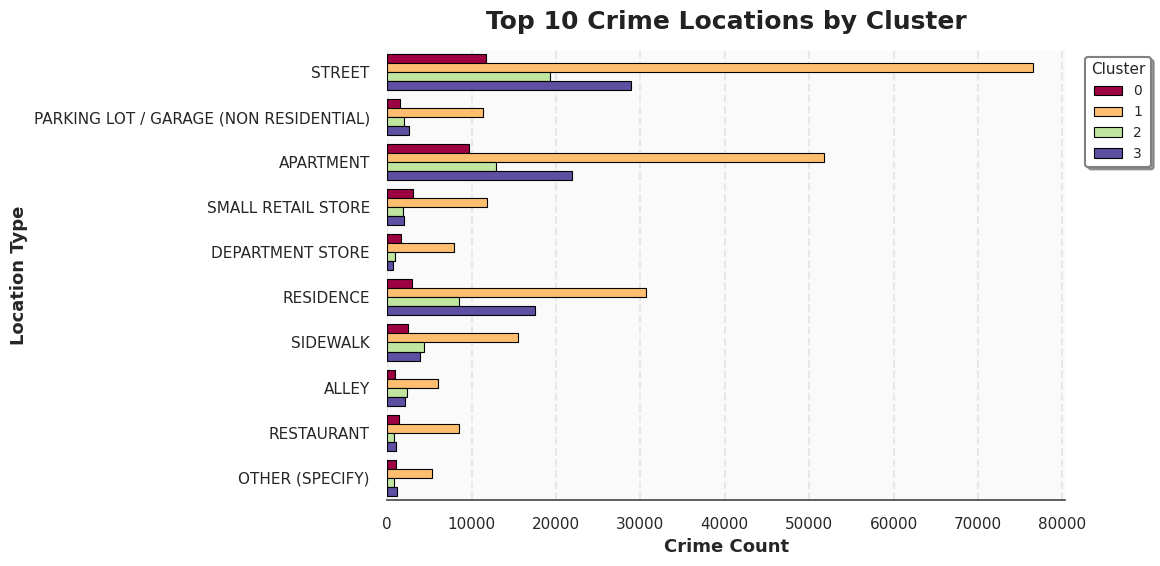

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = df_cluster.loc[X.index].copy()
df_pca['pca1'] = X_pca[:, 0]
df_pca['pca2'] = X_pca[:, 1]


top_locations = (
    df_pca['location_description']
    .value_counts()
    .head(10)
    .index
)
df_loc = df_pca[df_pca['location_description'].isin(top_locations)]


sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})


plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df_loc,
    y='location_description',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.8,
    saturation=1
)


ax.set_title(
    'Top 10 Crime Locations by Cluster',
    fontsize=18, weight='bold', pad=15, color='#222222'
)
ax.set_xlabel('Crime Count', fontsize=13, weight='semibold')
ax.set_ylabel('Location Type', fontsize=13, weight='semibold')


ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
sns.despine(left=True)


plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)


for spine in ax.spines.values():
    spine.set_edgecolor('#444444')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

# *Elbow by X Coordinate, Y Coordinate, Month, Year*

In [7]:
df_time_space = df.dropna(subset=['x_coordinate', 'y_coordinate', 'month', 'year']).copy()

features = ['x_coordinate', 'y_coordinate', 'month', 'year']
X = df_time_space[features]

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

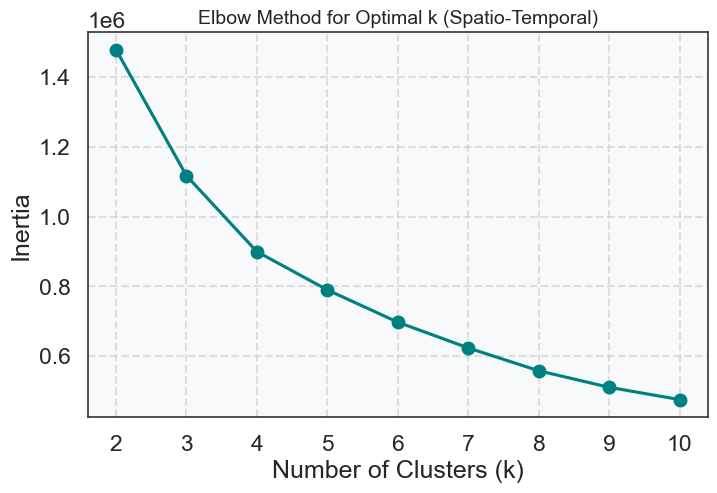

In [10]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='teal')
plt.title('Elbow Method for Optimal k (Spatio-Temporal)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# *Clusters by X Coordinate, Y Coordinate*

In [9]:
k_values = 4
kmeans_final = KMeans(n_clusters=k_values, random_state=42, n_init=10)
df_time_space['cluster_st'] = kmeans_final.fit_predict(X_scaled)

In [12]:
sample_idx = np.random.choice(len(X_scaled), size=3000, replace=False)
X_sample = X_scaled[sample_idx]
labels_sample = df_time_space['cluster_st'].iloc[sample_idx]


sil = silhouette_score(X_sample, labels_sample)

sil = silhouette_score(X_sample, labels_sample)

print(f"Silhouette Score: {sil:.4f}")

Silhouette Score: 0.3527


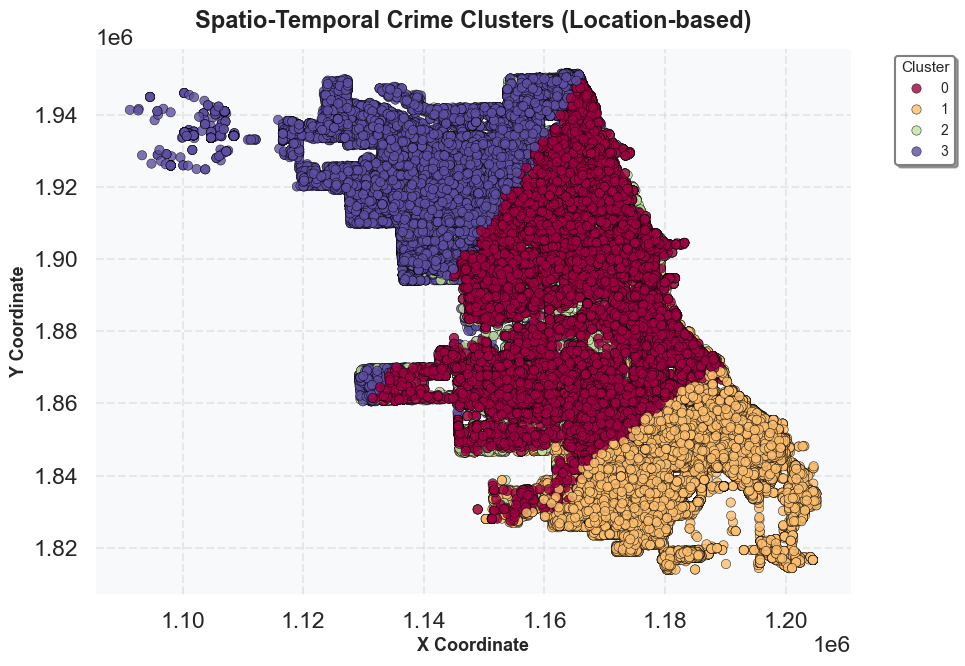

In [12]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'axes.facecolor': '#f8f9fa',
    'figure.facecolor': '#ffffff'
})

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=df_time_space,
    x='x_coordinate',
    y='y_coordinate',
    hue='cluster_st',
    palette='Spectral',
    s=45,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.4
)

ax.set_title('Spatio-Temporal Crime Clusters (Location-based)', fontsize=17, weight='bold', pad=15, color='#222222')
ax.set_xlabel('X Coordinate', fontsize=13, weight='semibold')
ax.set_ylabel('Y Coordinate', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    shadow=True,
    fontsize=10,
    title_fontsize=11
)

ax.grid(True, linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# *Clusters by Month, Crime Distributions*

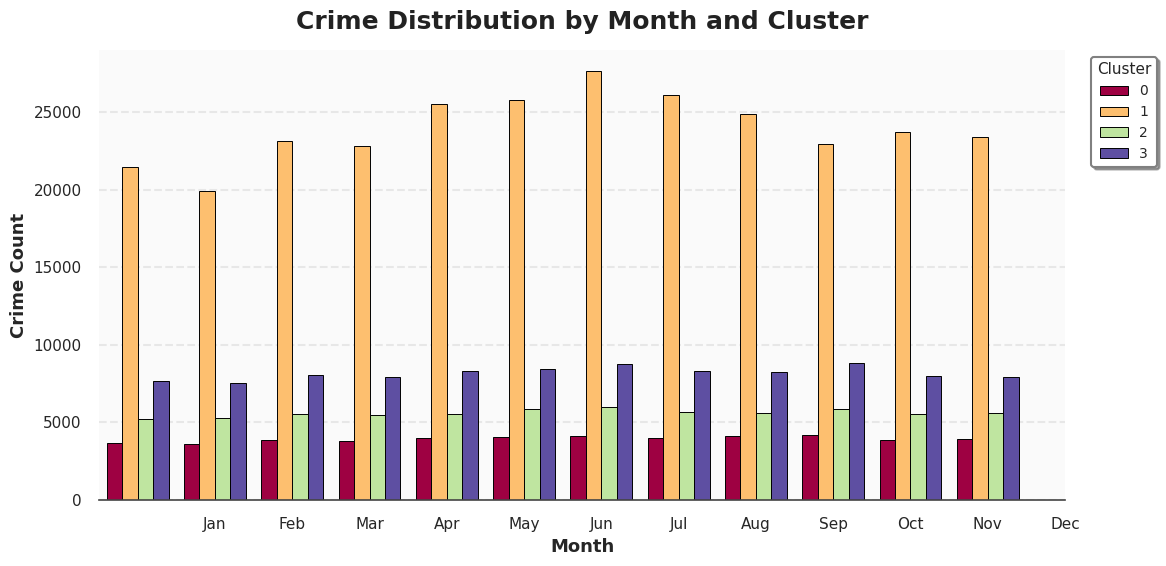

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = df_cluster.loc[X.index].copy()
df_pca['pca1'] = X_pca[:, 0]
df_pca['pca2'] = X_pca[:, 1]
df_time_space = df_pca.copy()

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df_time_space,
    x='month',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7,
    saturation=1
)

ax.set_title(
    'Crime Distribution by Month and Cluster',
    fontsize=18,
    weight='bold',
    pad=15,
    color='#222222'
)
ax.set_xlabel('Month', fontsize=13, weight='semibold')
ax.set_ylabel('Crime Count', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)

ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
sns.despine(left=True)

if df_time_space['month'].dtype != 'object':
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([
        'Jan','Feb','Mar','Apr','May','Jun',
        'Jul','Aug','Sep','Oct','Nov','Dec'
    ])

for spine in ax.spines.values():
    spine.set_edgecolor('#444444')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

In [37]:
month_summary = (
    df_time_space
    .groupby(['month_name', 'year'])['cluster_st']
    .value_counts()
    .unstack(fill_value=0)
)

month_summary

cluster_st           0     1      2      3
month_name year                           
April      2024   2212  8069      0  10190
           2025  18031   689      0    851
August     2024      0  7877   7694   7395
           2025  19945   578      0    567
December   2023      0  3269  17636    417
           2024      0  1081  18236    255
February   2024   2001  7620      0  10314
           2025  15127   593      0    749
January    2024   2173  7376      0  10068
           2025  16832   677      0    912
July       2024      0  8921   5341   9817
           2025  21311   634      0    554
June       2024     33  9234   2841  11054
           2025  19881   534      0    586
March      2024   2156  8078      0  10669
           2025  18184   689      0    813
May        2024   3132  8837      0  11005
           2025  19102   589      0    693
November   2023      0  3982  16581    856
           2024      0   955  18380    373
October    2023      0   913   2622    222
           2024      0  6188  12674   3596
           2025  14743   488      0    396
September  2024      0  7203  10237   5506
           2025  18775   636      0    552

# *Elbow by X Coordinate, Y Coordinate, Month, Year, Day*

In [15]:
df_day_space = df.dropna(subset=['x_coordinate', 'y_coordinate', 'month', 'year', 'day']).copy()

features = ['x_coordinate', 'y_coordinate', 'month', 'year', 'day']
X = df_day_space[features]

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

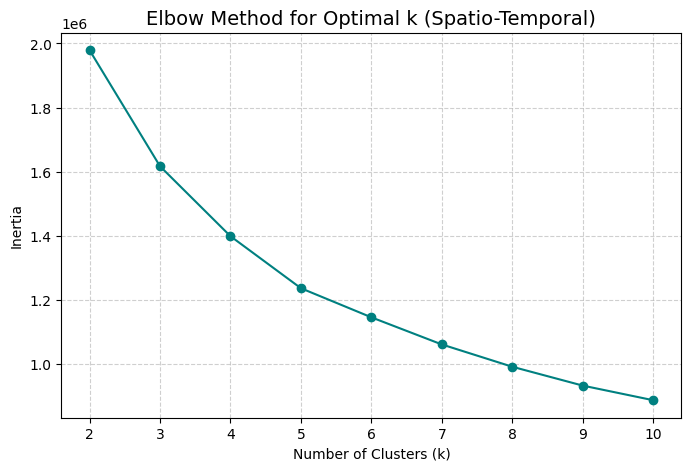

In [ ]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='teal')
plt.title('Elbow Method for Optimal k (Spatio-Temporal)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# *Cluster by X Coordinate, Y Coordinate, Month, Year, Day*

In [17]:
k_values = 4
kmeans_final = KMeans(n_clusters=k_values, random_state=42, n_init=10)
df_time_space['cluster_st'] = kmeans_final.fit_predict(X_scaled)

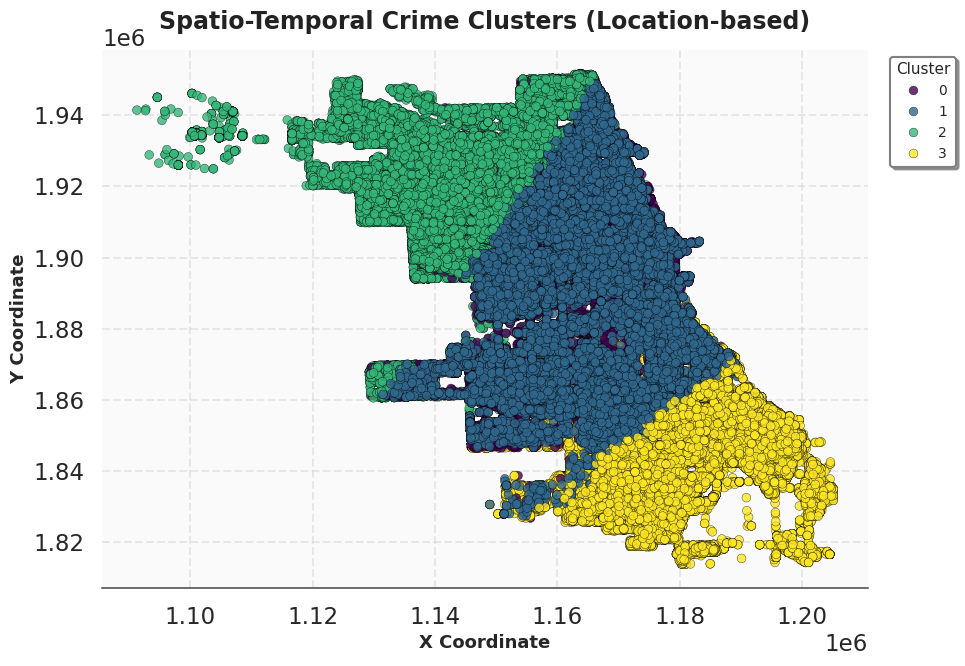

In [18]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=df_time_space,
    x='x_coordinate',
    y='y_coordinate',
    hue='cluster_st',
    palette='viridis',
    s=40,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.3
)

ax.set_title(
    'Spatio-Temporal Crime Clusters (Location-based)',
    fontsize=17,
    weight='bold',
    pad=15,
    color='#222222'
)
ax.set_xlabel('X Coordinate', fontsize=13, weight='semibold')
ax.set_ylabel('Y Coordinate', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)

ax.grid(True, linestyle='--', alpha=0.4)
sns.despine(left=True)

for spine in ax.spines.values():
    spine.set_edgecolor('#444444')
    spine.set_linewidth(1.1)

plt.tight_layout()
plt.show()

# *Cluster Visuals Crime Distribution by Month*

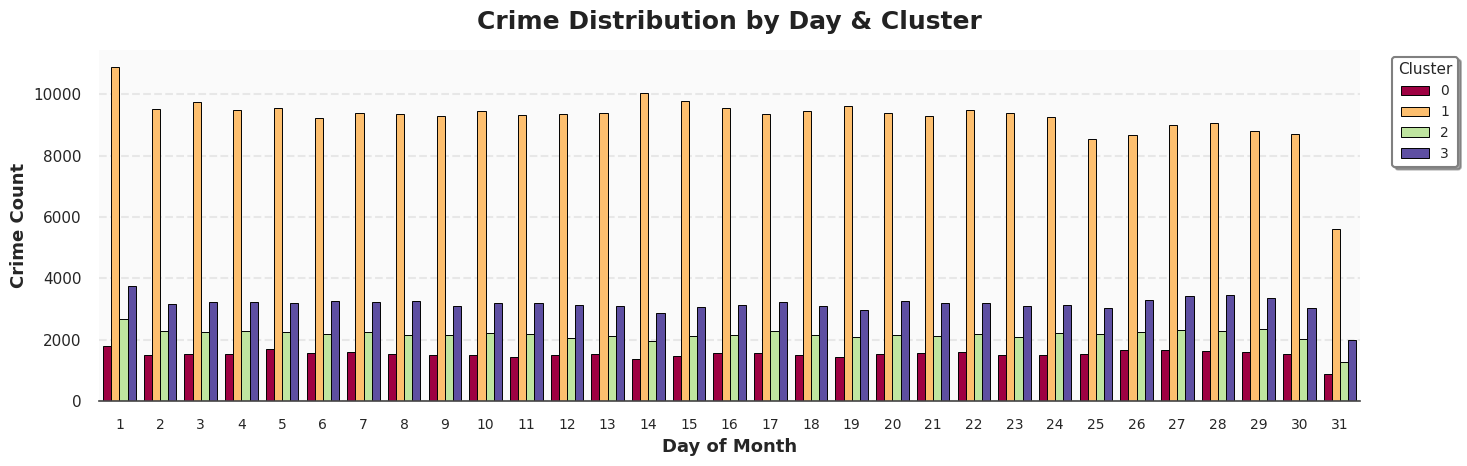

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = df_cluster.loc[X.index].copy()
df_pca['pca1'] = X_pca[:, 0]
df_pca['pca2'] = X_pca[:, 1]
df_time_space = df_pca.copy()

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})

plt.figure(figsize=(15, 5))
ax = sns.countplot(
    data=df_time_space,
    x='day',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7,
    saturation=1
)

ax.set_title(
    'Crime Distribution by Day & Cluster',
    fontsize=18,
    weight='bold',
    pad=15,
    color='#222222'
)
ax.set_xlabel('Day of Month', fontsize=13, weight='semibold')
ax.set_ylabel('Crime Count', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)

ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.tick_params(axis='y', labelsize=11)
sns.despine(left=True)

for spine in ax.spines.values():
    spine.set_edgecolor('#444444')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

# *Elbow by Month, Day*

In [19]:
df_temporal = df.dropna(subset=['month', 'day']).copy()

X = df_temporal[['month', 'day']]

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

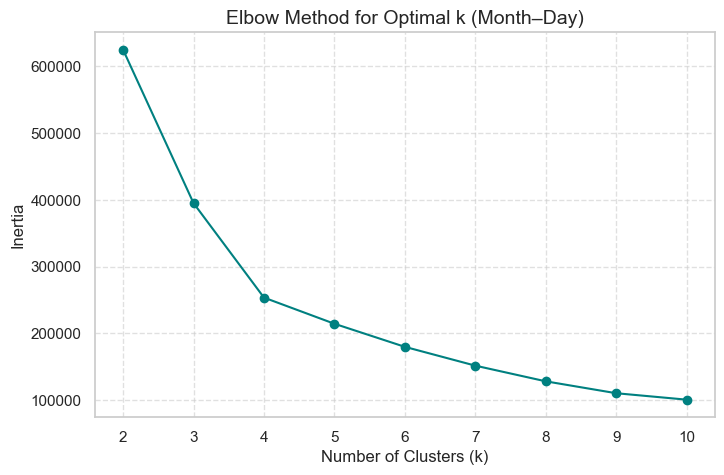

In [23]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='teal')
plt.title('Elbow Method for Optimal k (Month–Day)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **Cluster Visual by Month, Day**

In [21]:
k_nums = 4
kmeans_final = KMeans(n_clusters=k_nums, random_state=42, n_init=10)
df_temporal['cluster_month_day'] = kmeans_final.fit_predict(X_scaled)

C:\Users\saran\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


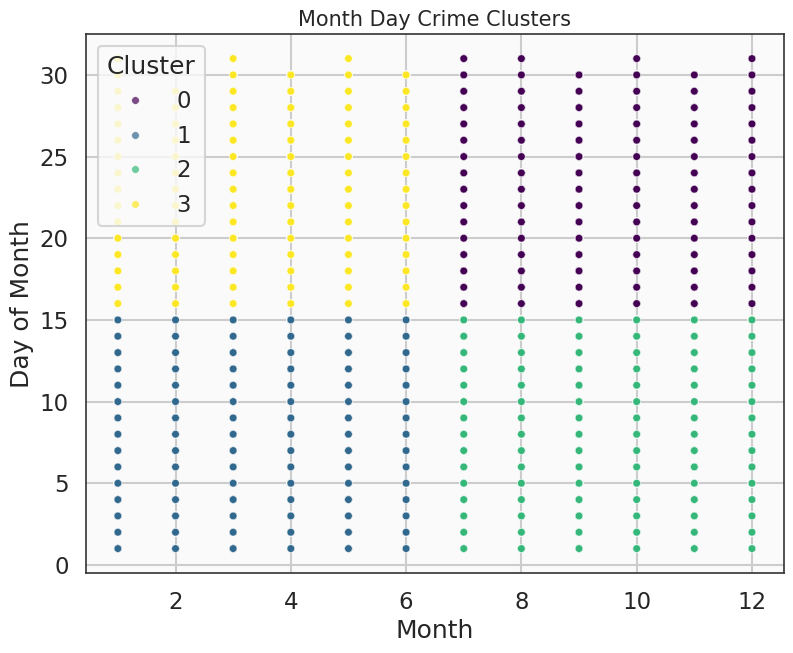

In [19]:
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df_temporal,
    x='month',
    y='day',
    hue='cluster_month_day',
    palette='viridis',
    s=30,
    alpha=0.7
)
plt.title(f'Month Day Crime Clusters', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Day of Month')
plt.legend(title='Cluster')
plt.show()

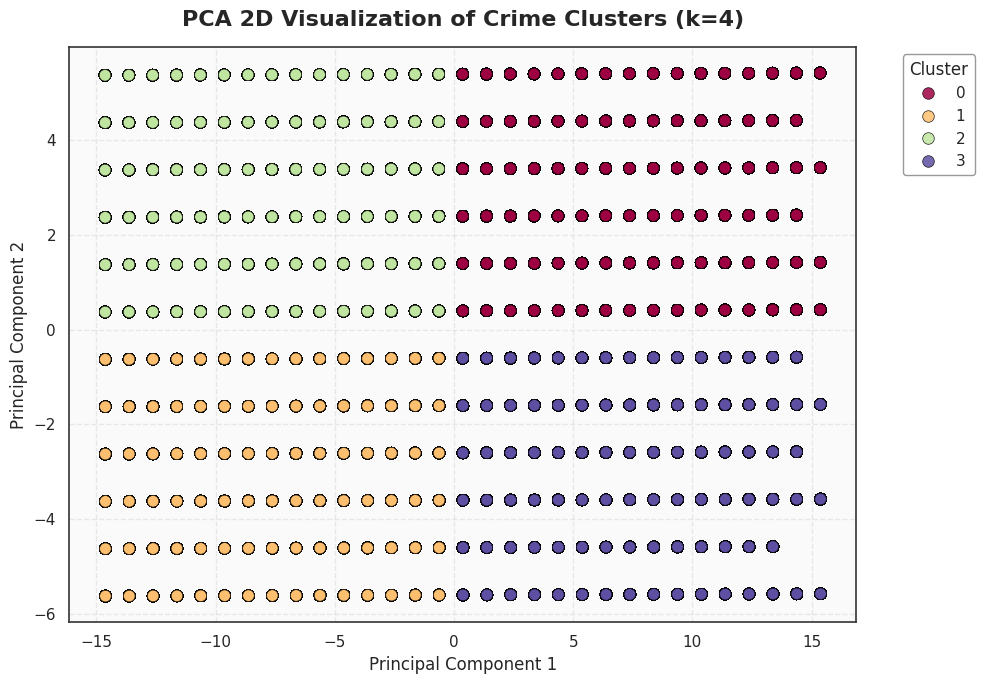

In [ ]:
X_temp = df_temporal[['month', 'day']]


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_temp)


df_temporal['PCA1'] = X_pca[:, 0]
df_temporal['PCA2'] = X_pca[:, 1]


sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})


plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    data=df_temporal,
    x='PCA1',
    y='PCA2',
    hue='cluster_month_day',
    palette='Spectral',
    s=70,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85
)


plt.title(f'Visualization of Crime Clusters', fontsize=16, weight='bold', pad=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Elbow by Latitude, Longitude, Description, Location**

In [23]:
df_behavioral = df.dropna(subset=['latitude', 'longitude', 'description', 'location']).copy()

le_desc = LabelEncoder()
le_loc = LabelEncoder()


In [24]:
df_behavioral['desc_encoded'] = le_desc.fit_transform(df_behavioral['description'].astype(str))
df_behavioral['loc_encoded'] = le_loc.fit_transform(df_behavioral['location'].astype(str))

df_behavioral['arrest'] = df_behavioral['arrest'].astype(int)
df_behavioral['domestic'] = df_behavioral['domestic'].astype(int)

In [25]:
features = ['desc_encoded', 'arrest', 'domestic', 'latitude', 'longitude']
X = df_behavioral[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

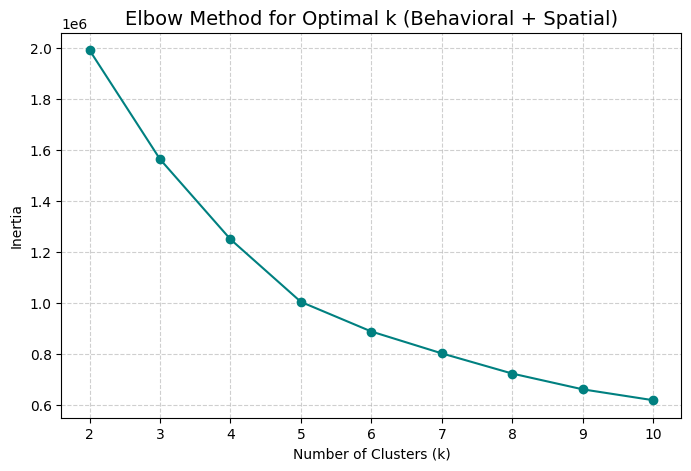

In [ ]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='teal')
plt.title('Elbow Method for Optimal k (Behavioral + Spatial)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **Clusters by Longitude, Latitude, Behavioral + Spatial Crime**

In [26]:
k_optim = 4
kmeans_final = KMeans(n_clusters=k_optim, random_state=42, n_init=10)
df_behavioral['cluster_behavior'] = kmeans_final.fit_predict(X_scaled)

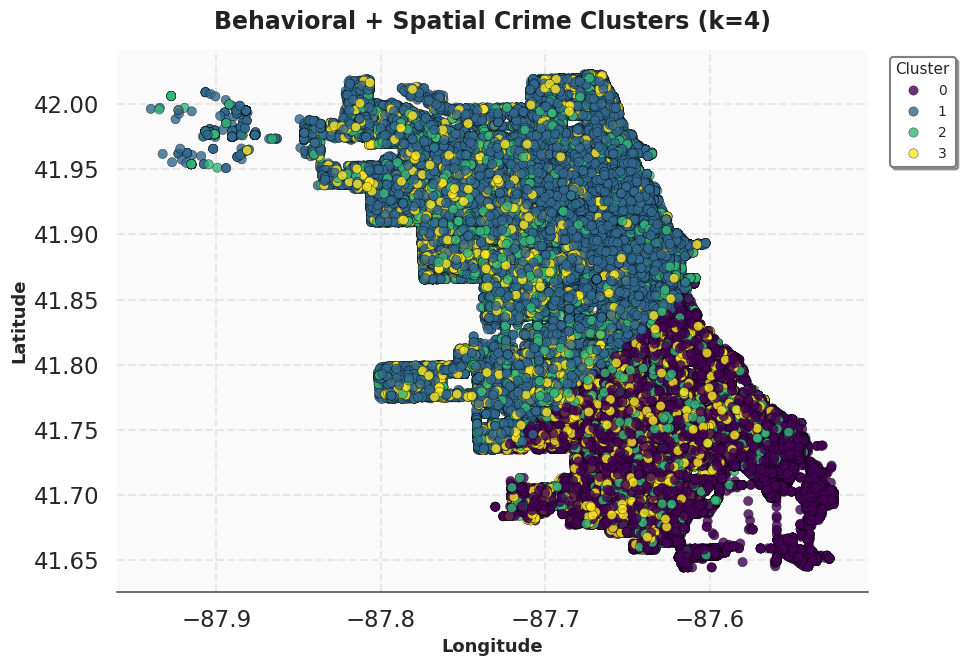

In [27]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=df_behavioral,
    x='longitude',
    y='latitude',
    hue='cluster_behavior',
    palette='viridis',
    s=45,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.3
)

ax.set_title(
    f'Behavioral + Spatial Crime Clusters (k={k_optim})',
    fontsize=17,
    weight='bold',
    pad=15,
    color='#222222'
)
ax.set_xlabel('Longitude', fontsize=13, weight='semibold')
ax.set_ylabel('Latitude', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)

ax.grid(True, linestyle='--', alpha=0.4)
sns.despine(left=True)

for spine in ax.spines.values():
    spine.set_edgecolor('#444444')
    spine.set_linewidth(1.1)

plt.tight_layout()
plt.show()

# **Clusters Visuals by Arrest Rate Per Cluster**

C:\Users\saran\AppData\Local\Temp\ipykernel_9732\2396659430.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\saran\AppData\Local\Temp\ipykernel_9732\2396659430.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


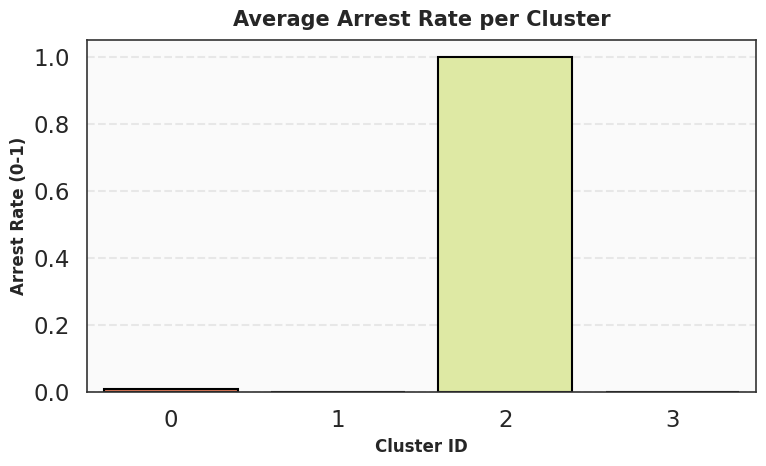

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_behavioral,
    x='cluster_behavior',
    y='arrest',
    estimator=np.mean,
    palette='Spectral',
    edgecolor='black',
    ci=None
)
plt.title('Average Arrest Rate per Cluster', fontsize=15, weight='bold', pad=10)
plt.xlabel('Cluster ID', fontsize=12, weight='semibold')
plt.ylabel('Arrest Rate (0-1)', fontsize=12, weight='semibold')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Cluster Visuals by Domestic Crime Per Clusters**

C:\Users\saran\AppData\Local\Temp\ipykernel_9732\1528074994.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\saran\AppData\Local\Temp\ipykernel_9732\1528074994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


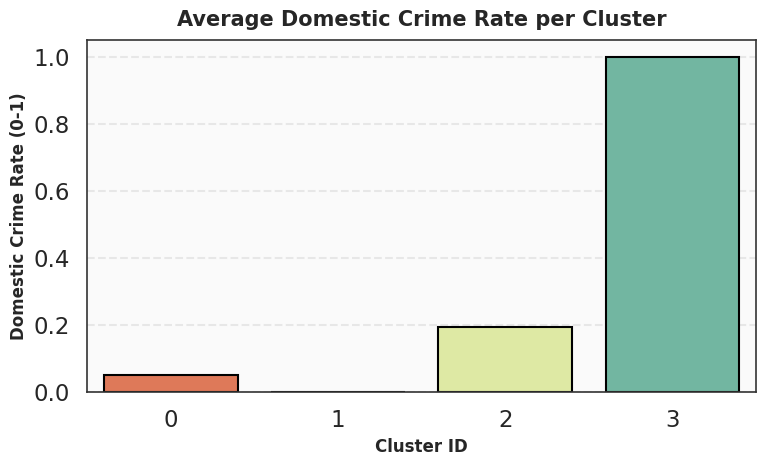

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_behavioral,
    x='cluster_behavior',
    y='domestic',
    estimator=np.mean,
    palette='Spectral',
    edgecolor='black',
    ci=None
)
plt.title('Average Domestic Crime Rate per Cluster', fontsize=15, weight='bold', pad=10)
plt.xlabel('Cluster ID', fontsize=12, weight='semibold')
plt.ylabel('Domestic Crime Rate (0-1)', fontsize=12, weight='semibold')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Top 10 Crime Descriptions by Clusters**

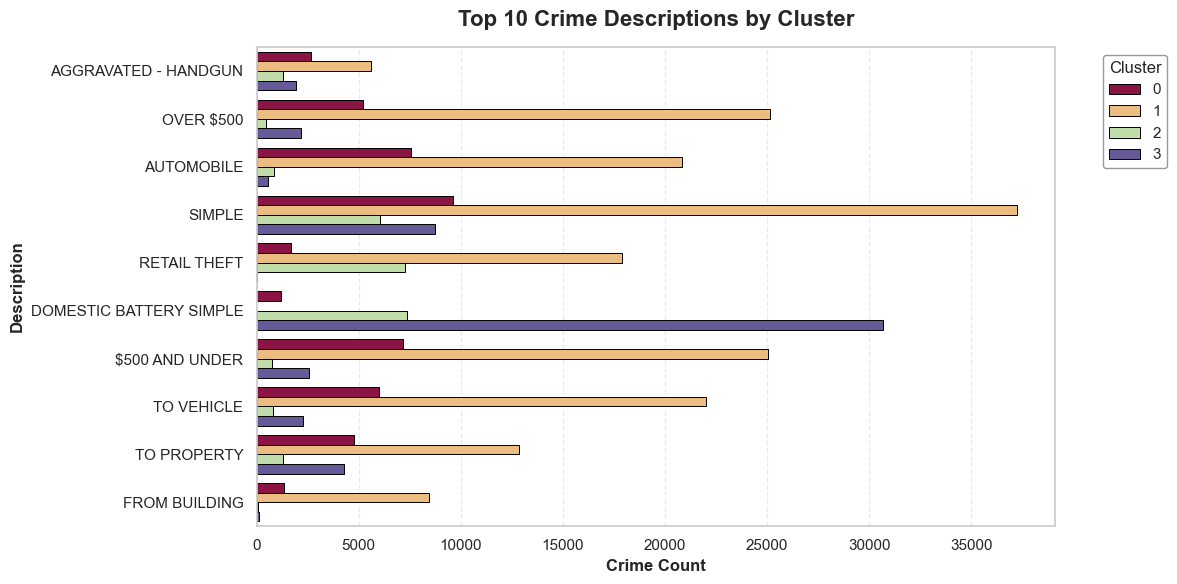

In [21]:
top_desc = df_behavioral['description'].value_counts().head(10).index
df_topdesc = df_behavioral[df_behavioral['description'].isin(top_desc)]

plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_topdesc,
    y='description',
    hue='cluster_behavior',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Top 10 Crime Descriptions by Cluster', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Crime Count', fontsize=12, weight='semibold')
ax.set_ylabel('Description', fontsize=12, weight='semibold')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# *Elbow by Ward, Community Areas*

In [28]:
df_geo = df.dropna(subset=['ward', 'community_area', 'x_coordinate', 'y_coordinate']).copy()

features = ['ward', 'community_area', 'x_coordinate', 'y_coordinate']
X = df_geo[features]

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

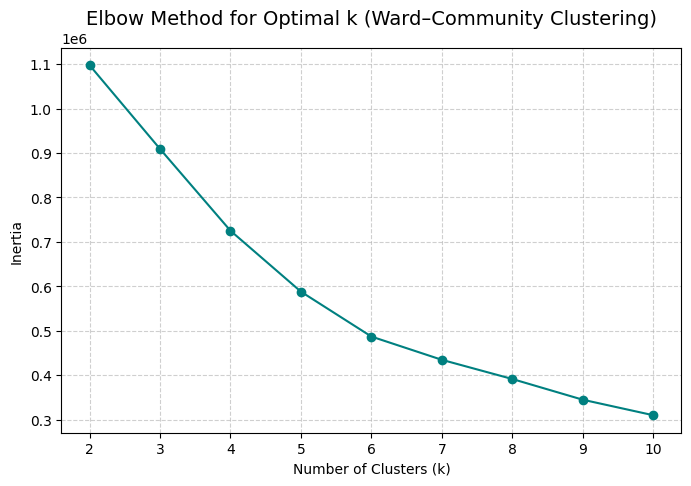

In [ ]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='teal')
plt.title('Elbow Method for Optimal k (Ward–Community Clustering)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# **Clusters Visuals by Ward-Community**

In [30]:
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_geo['cluster_geo'] = kmeans_final.fit_predict(X_scaled)


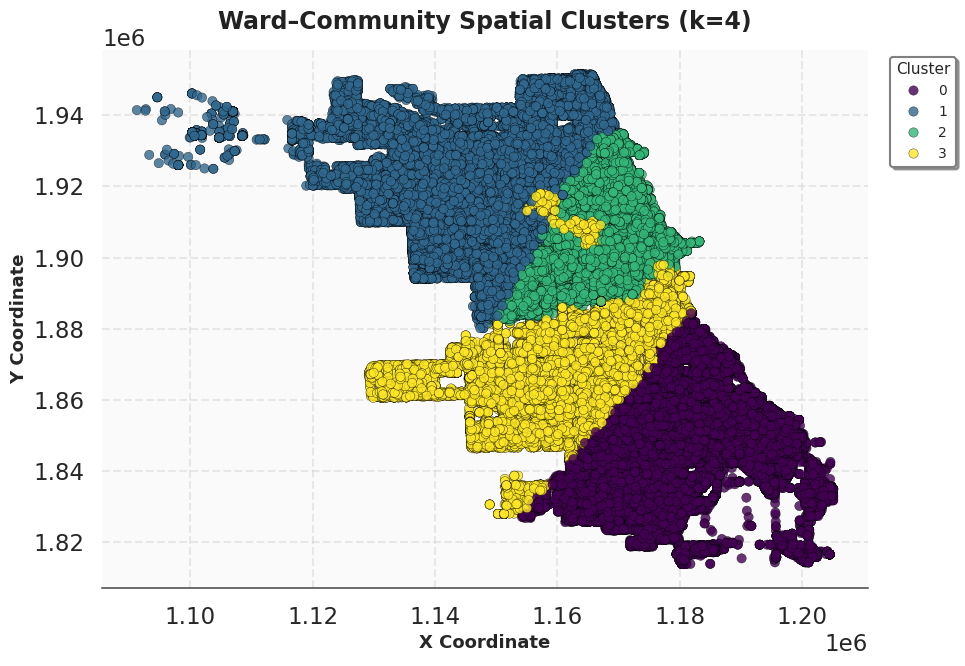

In [31]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#fafafa'
})

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=df_geo,
    x='x_coordinate',
    y='y_coordinate',
    hue='cluster_geo',
    palette='viridis',
    s=45,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.3
)

ax.set_title(
    f'Ward–Community Spatial Clusters (k={k_optimal})',
    fontsize=17,
    weight='bold',
    pad=15,
    color='#222222'
)
ax.set_xlabel('X Coordinate', fontsize=13, weight='semibold')
ax.set_ylabel('Y Coordinate', fontsize=13, weight='semibold')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    shadow=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    title_fontsize=11
)

ax.grid(True, linestyle='--', alpha=0.4)
sns.despine(left=True)

for spine in ax.spines.values():
    spine.set_edgecolor('#444444')
    spine.set_linewidth(1.1)

plt.tight_layout()
plt.show()

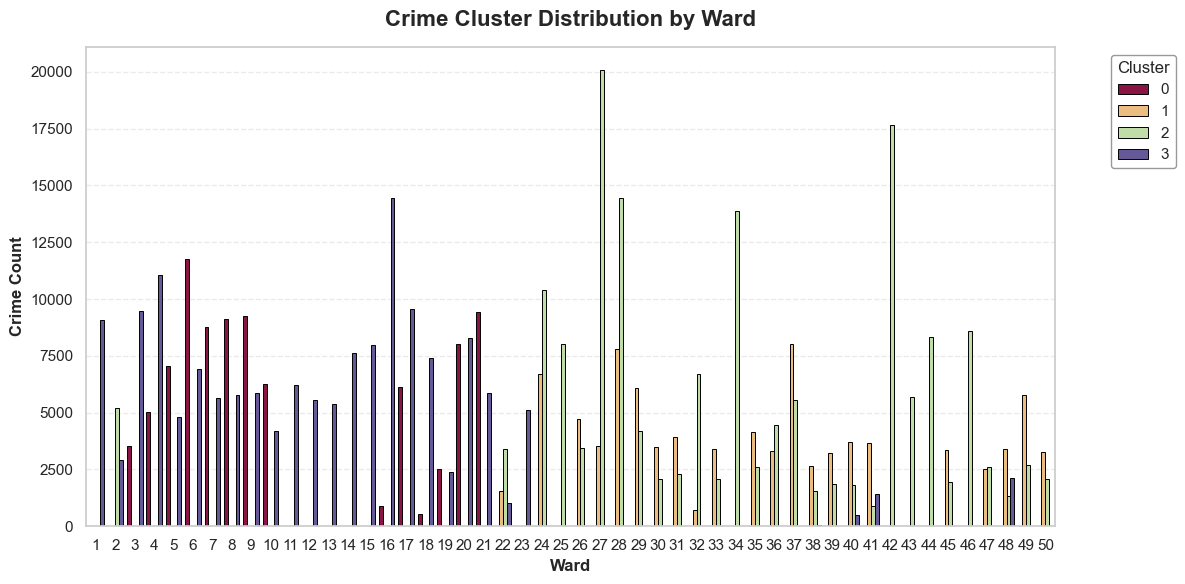

In [27]:
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_geo,
    x='ward',
    hue='cluster_geo',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Crime Cluster Distribution by Ward', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Ward', fontsize=12, weight='semibold')
ax.set_ylabel('Crime Count', fontsize=12, weight='semibold')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='white', edgecolor='gray')
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

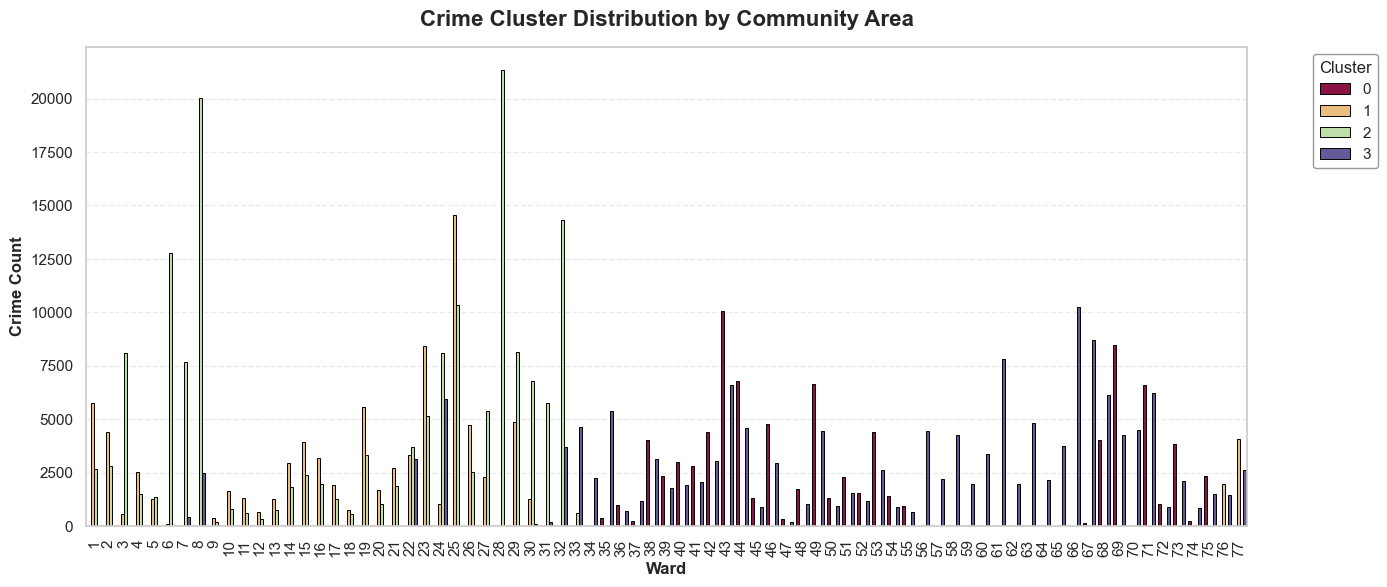

In [35]:
plt.figure(figsize=(14,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_geo,
    x='community_area',
    hue='cluster_geo',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Crime Cluster Distribution by Community Area', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Ward', fontsize=12, weight='semibold')
ax.set_ylabel('Crime Count', fontsize=12, weight='semibold')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='white', edgecolor='gray')
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

# **Hierarchical Clustering**

# *Hierarchical Clustering using Dendrogram*

In [32]:
df_sample = df.sample(3000, random_state=42)
df_cluster = df_sample.dropna(subset=['latitude', 'longitude']).copy()
X = df_cluster[['latitude', 'longitude']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

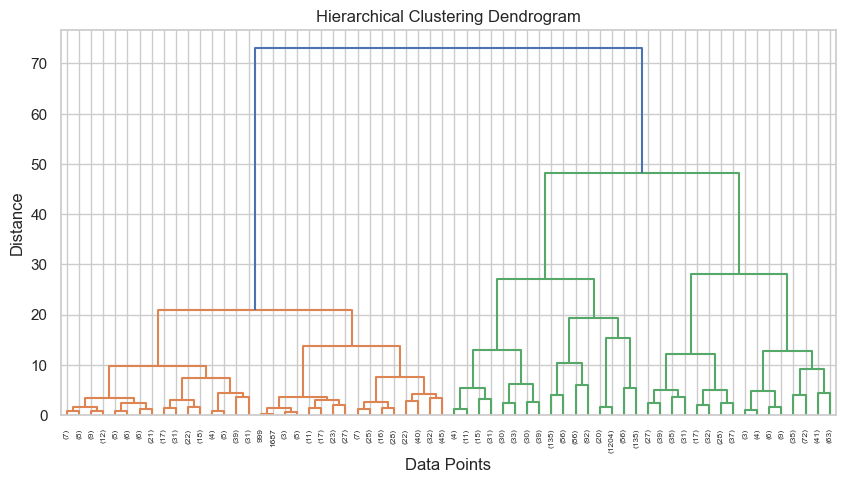

In [38]:
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


In [40]:
silhouette_scores = []
K = range(2, 11)

print("Silhouette Scores for Agglomerative Clustering:\n")
for k in K:
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hc.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k}: Silhouette Score = {score:.4f}")



Silhouette Scores for Agglomerative Clustering:

k = 2: Silhouette Score = 0.5570
k = 3: Silhouette Score = 0.5416
k = 4: Silhouette Score = 0.5267
k = 5: Silhouette Score = 0.5491
k = 6: Silhouette Score = 0.5436
k = 7: Silhouette Score = 0.5334
k = 8: Silhouette Score = 0.5612
k = 9: Silhouette Score = 0.5618
k = 10: Silhouette Score = 0.5693


# *Visuals with Longitude, Latitude*

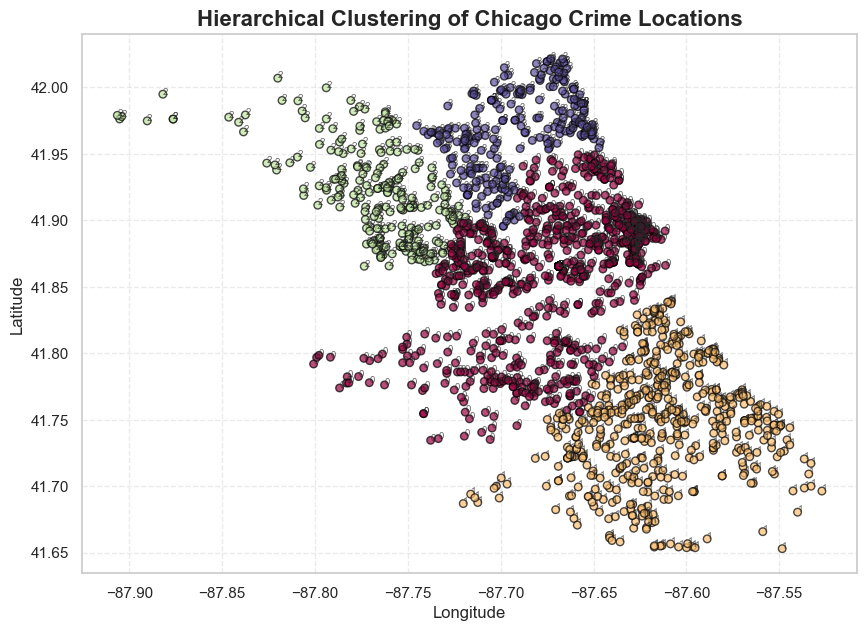

In [48]:

plt.figure(figsize=(10,7))
scatter = plt.scatter(
    df_cluster['longitude'], 
    df_cluster['latitude'], 
    c=df_cluster['cluster'], 
    cmap='Spectral', 
    s=30, 
    alpha=0.7,
    edgecolor='black'
)

for i, txt in enumerate(df_cluster['cluster']):
    plt.text(
        df_cluster['longitude'].iloc[i],
        df_cluster['latitude'].iloc[i],
        str(txt),
        fontsize=7,
        alpha=0.7
    )

plt.title('Hierarchical Clustering of Chicago Crime Locations', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [110]:
silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.5693


# *Top 10 Primary Type  Visuals*  

In [33]:
top10_primary = df_cluster['primary_type'].value_counts().head(10).index

df_top10 = df_cluster[df_cluster['primary_type'].isin(top10_primary)]

C:\Users\saran\AppData\Local\Temp\ipykernel_1248\722297508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['PCA1'] = X_pca[:, 0]
C:\Users\saran\AppData\Local\Temp\ipykernel_1248\722297508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['PCA2'] = X_pca[:, 1]


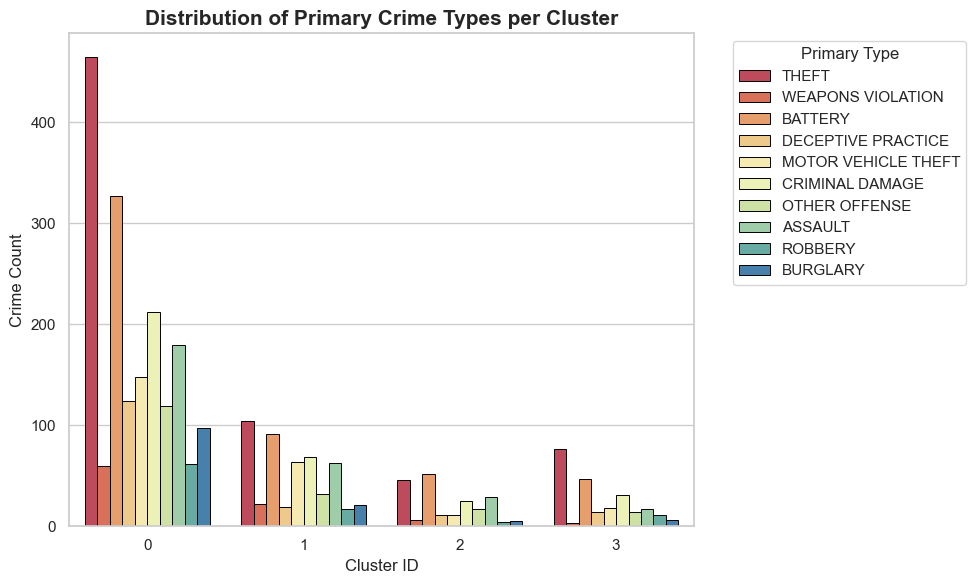

In [50]:
X_temp = df_top10[['month', 'day', 'hour', 'time_float']]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_temp)

df_top10['PCA1'] = X_pca[:, 0]
df_top10['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_top10,
    x='cluster',
    hue='primary_type',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Distribution of Primary Crime Types per Cluster', fontsize=15, weight='bold')
ax.set_xlabel('Cluster ID', fontsize=12)
ax.set_ylabel('Crime Count', fontsize=12)
plt.legend(title='Primary Type', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()



# *Top 10 Location Description Visuals*

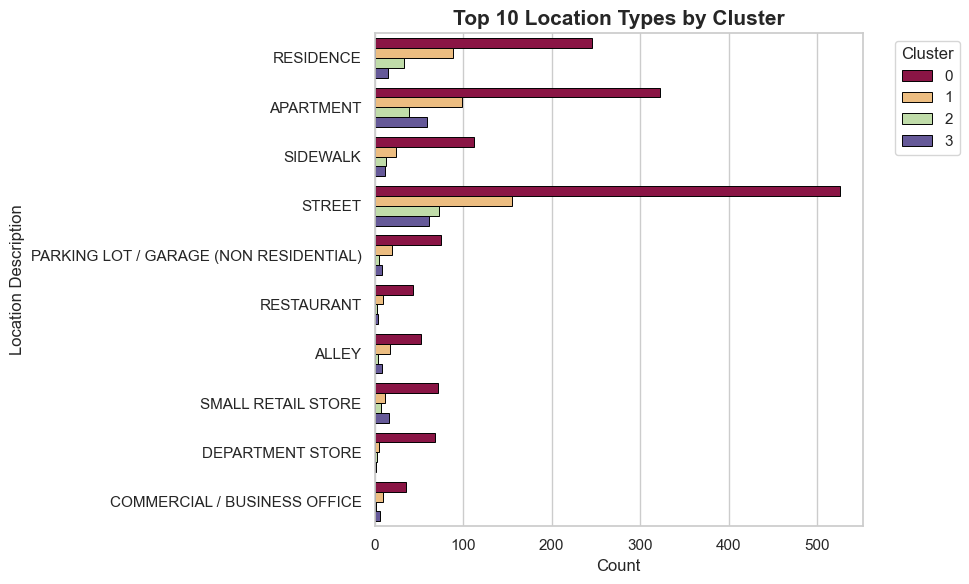

In [ ]:
top_locations = df_cluster['location_description'].value_counts().head(10).index
df_toploc = df_cluster[df_cluster['location_description'].isin(top_locations)]

plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_toploc,
    y='location_description',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Top 10 Location Types by Cluster', fontsize=15, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Location Description', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()




# *Clusters With X Coordinate, Y Coordinate, Month, Year*

In [42]:
df_sample = df.sample(3000, random_state=42)
df_coordinate = df_sample.dropna(subset=['x_coordinate', 'y_coordinate', 'month', 'year']).copy()
X = df_coordinate[['x_coordinate', 'y_coordinate', 'month', 'year']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Silhouette Scores for Agglomerative Clustering:

k = 2: Silhouette Score = 0.2578
k = 3: Silhouette Score = 0.3150
k = 4: Silhouette Score = 0.3296
k = 5: Silhouette Score = 0.3356
k = 6: Silhouette Score = 0.3377
k = 7: Silhouette Score = 0.3203
k = 8: Silhouette Score = 0.3335
k = 9: Silhouette Score = 0.3329
k = 10: Silhouette Score = 0.3389


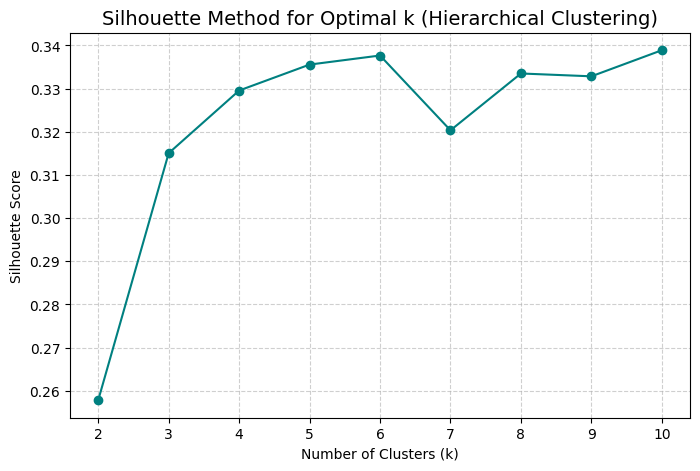

In [14]:
silhouette_scores = []
K = range(2, 11)

print("Silhouette Scores for Agglomerative Clustering:\n")
for k in K:
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hc.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, 'o-', color='teal')
plt.title('Silhouette Method for Optimal k (Hierarchical Clustering)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# *Cluster Visuals*

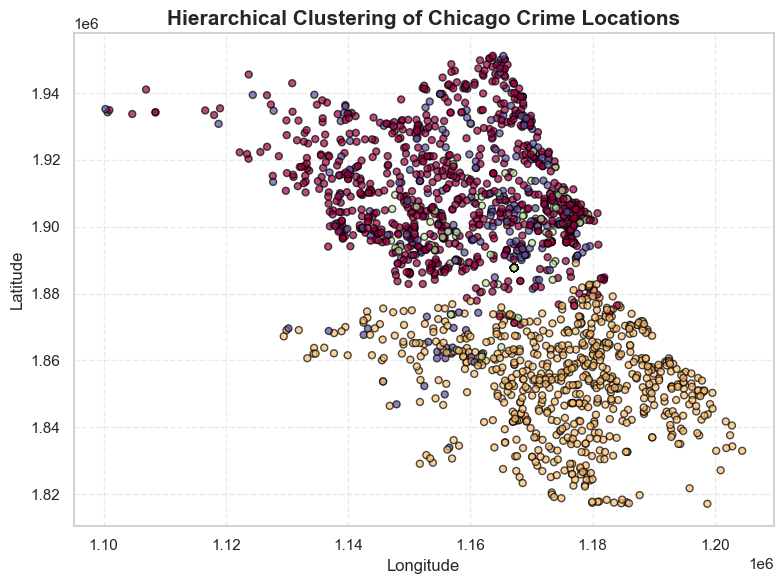

In [44]:
hc_final = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_coordinate['cluster'] = hc_final.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    df_coordinate['x_coordinate'],
    df_coordinate['y_coordinate'],
    c=df_coordinate['cluster'],
    cmap='Spectral',
    s=25,
    alpha=0.7,
    edgecolor='black'
)
plt.title('Hierarchical Clustering of Chicago Crime Locations', fontsize=15, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# *Month and Clusters Visuals*

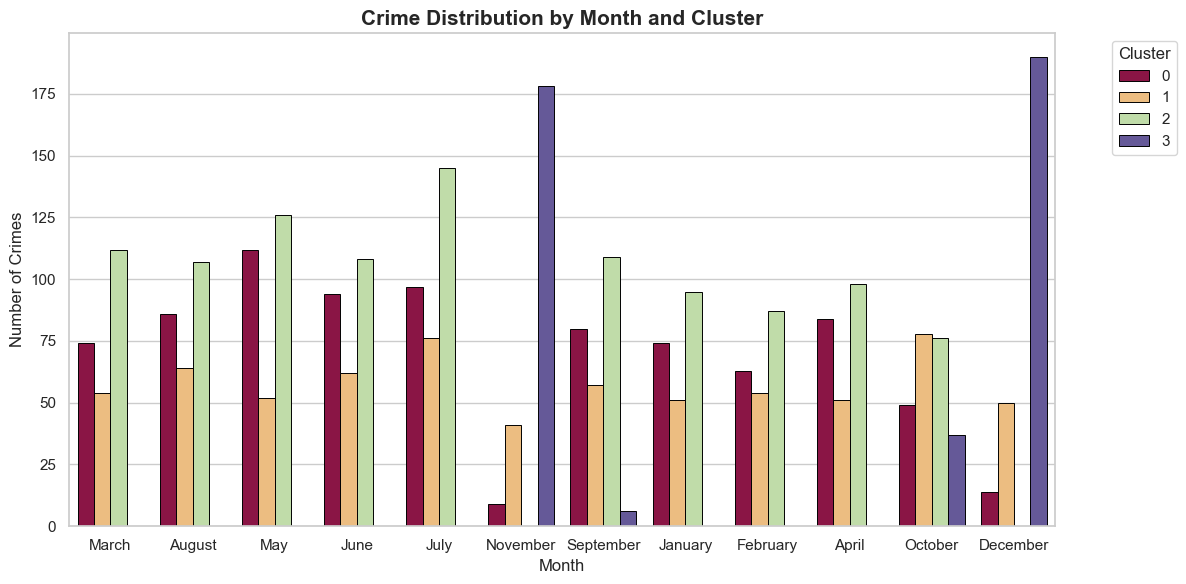

In [45]:
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_coordinate,
    x='month_name',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Crime Distribution by Month and Cluster', fontsize=15, weight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

# **DBSCAN**

# *DBSCAN with longitude, latitude*

In [53]:
df_sample = df.sample(3000, random_state=42).copy()


df_sample = df_sample.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
df_cluster = df_sample[['latitude', 'longitude']].copy()



In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [55]:
dbscan = DBSCAN(eps=0.15, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

df_sample['cluster'] = labels

In [61]:
mask = df_sample['cluster'] != -1
X_valid = X_scaled[mask]
labels_valid = df_sample.loc[mask, 'cluster']

if len(set(labels_valid)) > 1:
    sil = silhouette_score(X_valid, labels_valid)
    print(f"Silhouette Score: {sil:.4f}")
    
else:
    print("Not enough clusters (or all noise) for metric calculation.")


Silhouette Score: 0.5544


# *DBSCAN With latitude, longitude visuals*

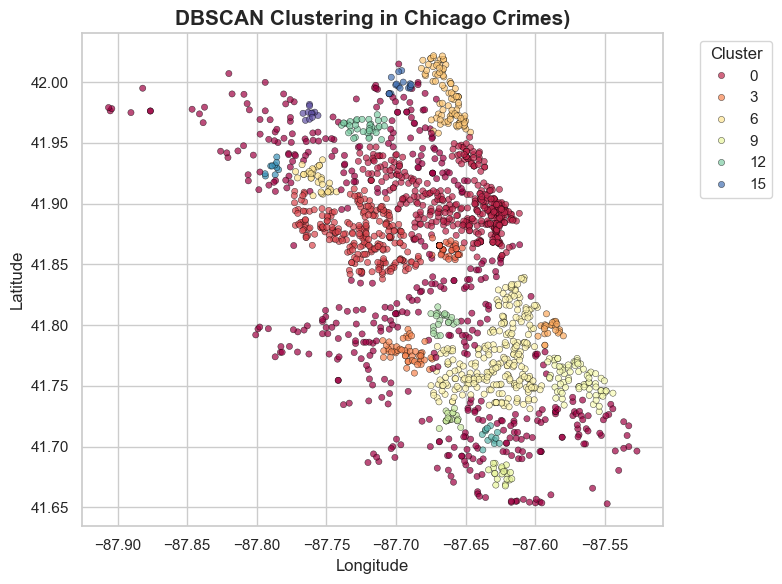

In [ ]:
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='cluster',
    data=df_sample,
    palette='Spectral',
    s=20,
    alpha=0.7,
    edgecolor='black'
)
plt.title('DBSCAN Clustering in Chicago Crimes)', fontsize=15, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


# *DBSCAN with Ward visuals* 

C:\Users\saran\AppData\Local\Temp\ipykernel_1248\1456216451.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\saran\AppData\Local\Temp\ipykernel_1248\1456216451.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='white', edgecolor='gray')


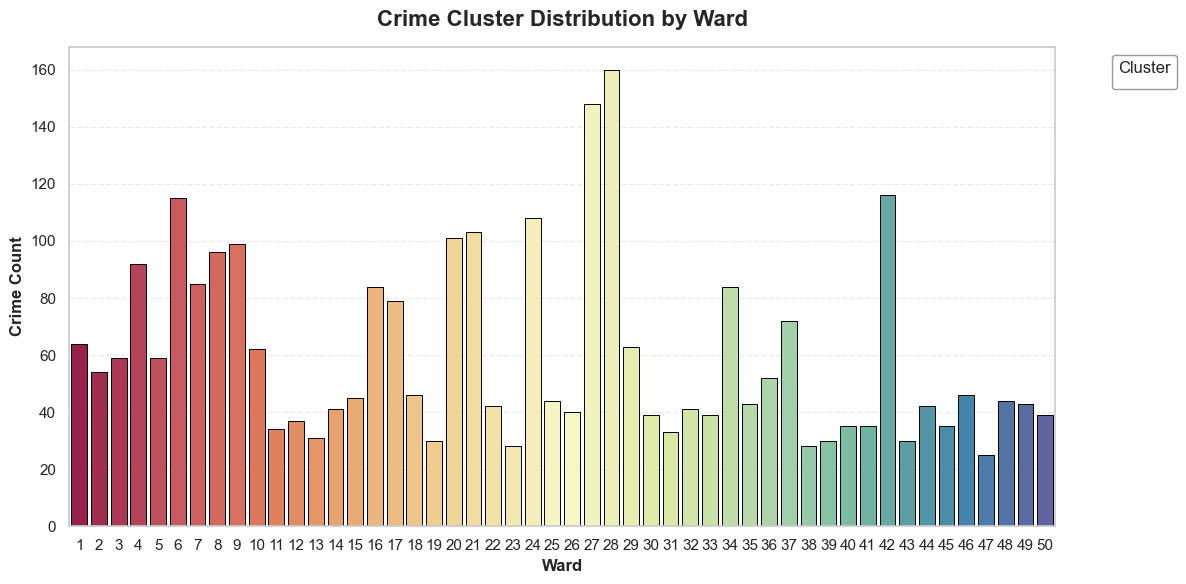

In [131]:
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_sample,
    x='ward',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Crime Cluster Distribution by Ward', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Ward', fontsize=12, weight='semibold')
ax.set_ylabel('Crime Count', fontsize=12, weight='semibold')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='white', edgecolor='gray')
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# *DBSCAN with Year, Longitude, Latitude*

In [67]:
df_sample = df_sample.dropna(subset=['year', 'longitude', 'latitude']).reset_index(drop=True)
df_cluster = df_sample[['latitude', 'longitude', 'year']].copy()

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [69]:
dbscan = DBSCAN(eps=0.15, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

df_sample['cluster'] = labels

In [70]:
mask = df_sample['cluster'] != -1
X_valid = X_scaled[mask]
labels_valid = df_sample.loc[mask, 'cluster']

if len(set(labels_valid)) > 1:
    sil = silhouette_score(X_valid, labels_valid)
    print(f"Silhouette Score: {sil:.4f}")
    
else:
    print("Not enough clusters (or all noise) for metric calculation.")

Silhouette Score: 0.7734


# *Year cluster  Visuals*

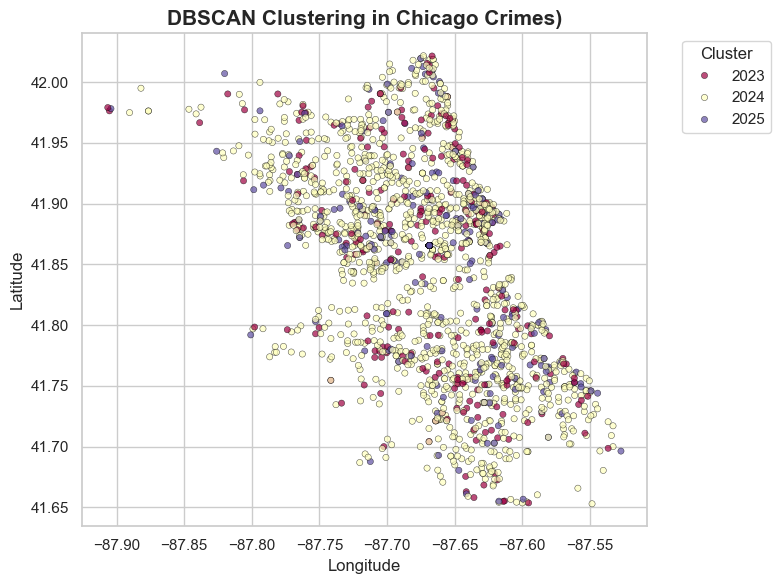

In [71]:
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='year',
    data=df_sample,
    palette='Spectral',
    s=20,
    alpha=0.7,
    edgecolor='black'
)
plt.title('DBSCAN Clustering in Chicago Crimes)', fontsize=15, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


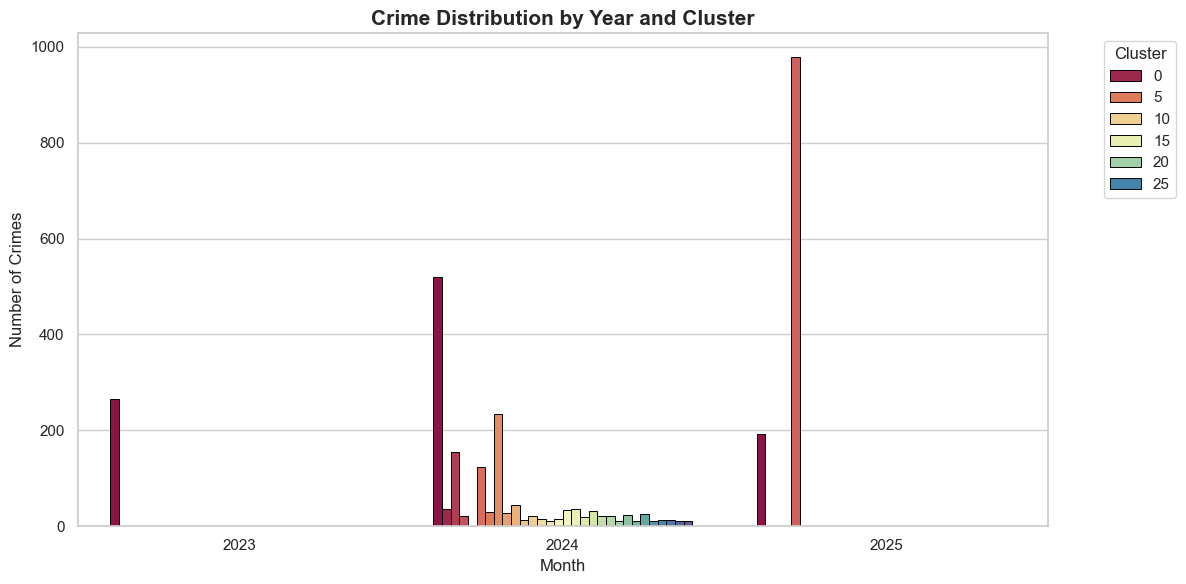

In [74]:
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_sample,
    x='year',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Crime Distribution by Year and Cluster', fontsize=15, weight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

# *Month Lattitude, Longitude Clusters*

In [90]:
df_sample = df_sample.dropna(subset=['longitude', 'latitude', "month", 'year']).reset_index(drop=True)
df_cluster = df_sample[['latitude', 'longitude', 'month', 'year']].copy()

In [91]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [127]:
dbscan = DBSCAN(eps=0.15, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

df_sample['cluster'] = labels

In [128]:
mask = df_sample['cluster'] != -1
X_valid = X_scaled[mask]
labels_valid = df_sample.loc[mask, 'cluster']

if len(set(labels_valid)) > 1:
    sil = silhouette_score(X_valid, labels_valid)
    print(f"Silhouette Score: {sil:.4f}")
    
else:
    print("Not enough clusters (or all noise) for metric calculation.")

Silhouette Score: 0.9965


# *Month, Longitude, Latitude visuals*

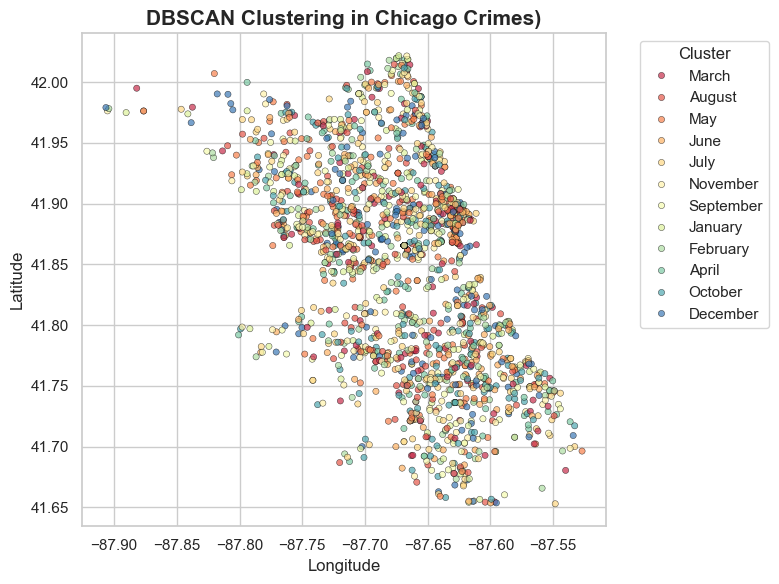

In [129]:
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='month_name',
    data=df_sample,
    palette='Spectral',
    s=20,
    alpha=0.7,
    edgecolor='black'
)
plt.title('DBSCAN Clustering in Chicago Crimes)', fontsize=15, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

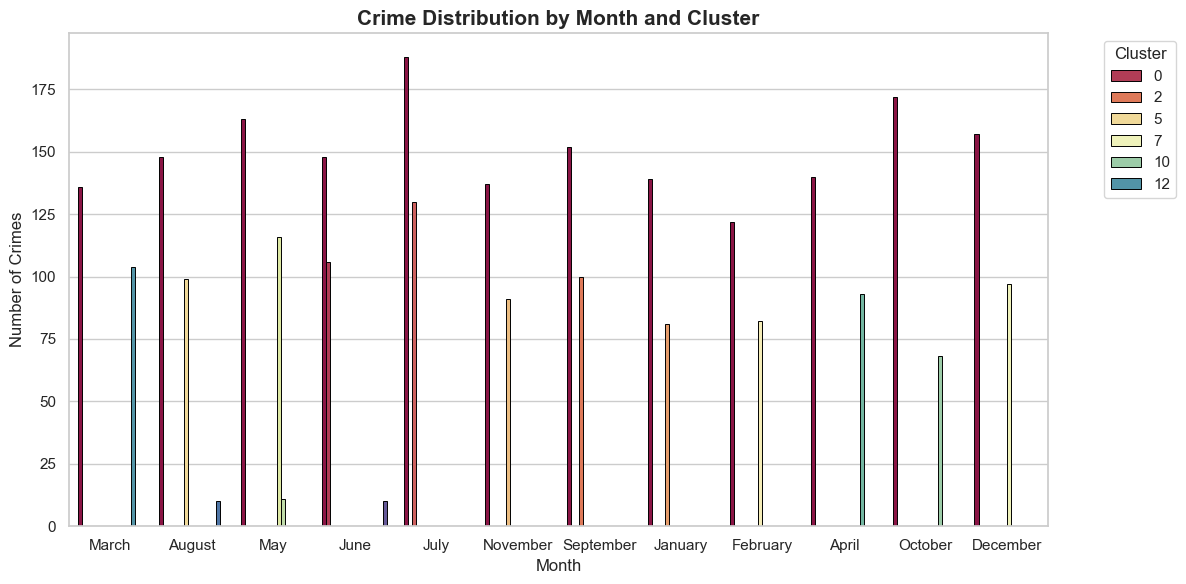

In [130]:
plt.figure(figsize=(12,6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(
    data=df_sample,
    x='month_name',
    hue='cluster',
    palette='Spectral',
    edgecolor='black',
    linewidth=0.7
)

ax.set_title('Crime Distribution by Month and Cluster', fontsize=15, weight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()